In [3]:
is_GOOGLE_COLAB = True

if is_GOOGLE_COLAB:

    import os
    import glob
    import shutil

    ERASE_EVERYTHING = True
    JOBNUMBER = 'test'
    ROOT_DIR = '/content/nnet_job' + str(JOBNUMBER) + '/' 

    print('NOTE: Files run with GPU will not appear here if running without GPU')

    if not os.path.isdir(ROOT_DIR):
        os.mkdir(ROOT_DIR)
    os.chdir(ROOT_DIR)

    print('Before erase:')
    !ls

    if ERASE_EVERYTHING:
        print('Erasing...')
        listing = glob.glob(ROOT_DIR + '*')
        for f in listing:
            if os.path.isfile(f):
                os.remove(f)
            else:
                shutil.rmtree(f)
        print('...Done.')


    print('After erase:')
    !ls

NOTE: Files run with GPU will not appear here if running without GPU
Before erase:
Erasing...
...Done.
After erase:


In [4]:
if is_GOOGLE_COLAB:
    from google.colab import files

    os.chdir(ROOT_DIR)
    uploaded = files.upload()

    for name, data in uploaded.items():
        with open(name, 'wb+') as f:
            f.write(data)
            print ('saved file', name)

    !ls

Saving nnet_data_compact.py to nnet_data_compact.py
Saving nnet_tensorflow_compact.py to nnet_tensorflow_compact.py
saved file nnet_data_compact.py
saved file nnet_tensorflow_compact.py
nnet_data_compact.py  nnet_tensorflow_compact.py


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import scipy.io

import os
import shutil

%load_ext autoreload
%autoreload 2

### **---------------------------------- EXPERIMENTS ----------------------------------------**

This is information for this example code. In this specific example, we construct 4-layers CNNs of different widths (100, 200, 400). We also explain the general meaning of all parameters and functions.

# **The function**

_ main_create_params() outputs all parameters to run the simulation of one specific neural net. In this particular example, each neural net has a distinct width.

_ main_run_experiment() runs the simulation, and outputs an object that contains the neural net simulation (nnet object).

_ main_save_results() and main_load_results() save and load results from Pickle files.

_ main_plot_results() takes as input a list of nnet objects, and plots the training/test loss/error of all nnet objects. These objects correspond to neural nets of different widths. One should see that all the plots collapse onto each other.


# **The parameters**

We explain the parameters to define a neural net. This is placed inside main_create_params(), via a dictionary **params**. It contains 4 other dictionaries, **neural_net**, **data**, **SGD**, **statsCollect**. 

## **neural_net**

** NOTE:** The code can specify MLP or CNN. The general structure of one layer is as follows:

Apply weight + bias ---> Nonlinearity ---> Pooling (if applied).

+ loss_choice: either 'squared' (output dimension must be 1) or 'cross entropy'

+ transfer_func: a list of activations at each layer (except for the output layer, which uses linear activation)

>> Each entry can be 'relu' or 'tanh'.

+ layer_type: a list specifying the layer type at all layers. Each entry is either 'fc' (fully-connected) or 'conv' (convolutional).

>> Constraint: this always ends with 'fc', and can only take the form ['conv', ..., 'conv', 'fc', ..., 'fc']. For example, ['fc', ..., 'fc'] and ['conv', 'conv', 'fc'] are valid, whereas ['conv', 'fc', 'conv', 'fc'] and ['conv', 'conv', 'conv'] are invalid.

+ layer_dim: a list specifying the dimensions at all layers. Each entry is a list, formatted depending on the corresponding layer type.

>> If the layer is 'fc', the entry is a list of 2 integers [input dimension, output dimension].

>> If the layer is 'conv', the entry is a list of 3 integers [filter width, filter height, number of neurons].

+ conv_strides: a list specifying the strides at all layers. Each entry is a list of 2 integers [width stride, height stride], and is ignored if the layer is 'fc'.

+ pool_dim: a list specifying the pooling sizes at all layers. Each entry can be either a list of 2 integers [width pooling size, height pooling size], or an empty list; it is ignored if the layer is 'fc'. Setting the entry to an empty list declares that there is no pooling.

+ pool_strides: a list specifying the pooling strides at all layers. Each entry can be either a list of 2 integers [width pooling stride, height pooling stride] if there is pooling, and is ignored if the layer is 'fc' or if the layer is 'conv' but there is no pooling.

+ pool_type: a list specifying the pooling types at all layers. Each entry can be either 'MAX' (max pooling) or 'AVG' (average pooling). It is ignored if the layer is 'fc' or if the layer is 'conv' but there is no pooling.

+ padding_type: defines the padding type everywhere. Either 'SAME' or 'VALID', as in Tensorflow.

+ W_init: a dictionary to specify the initialization of the weight matrix.

>> + 'params': a dictionary that provides the parameters for the chosen initialization scheme. Specifically, 'mean' and 'std', two lists specifying iid N(mean, std) initialization for each layer.

+ bias_init: a dictionary to specify the initialization of the bias.

>> + 'mean' and 'std': two numbers specifying iid N(mean, std) initialization for each layer.

+ GPU_which: specify the GPU to be used (usually 0 if there is only one GPU).

+ GPU_memory_fraction: the fraction of GPU memory to be used. Recommended to set at 0.99.

+ Tensorflow_randomSeed: the random seed for Tensorflow. Can be an integer or None.

+ dtype: data type to adjust the floating precision. Recommended: tf.float32.


## **data**

+ d: the data dimension, a list of 3 integers. For MNIST, [28, 28, 1]. For CIFAR-10, [32, 32, 3]. For isotropic Gaussians with input dimension D, [D, 1, 1]. For CIFAR-10 with pre-trained VGG16 features ('cifar10_feat' below), it must be calculated.

+ data_choice: 'mnist', 'cifar10', 'cifar10_feat' or 'isotropic Gaussian'.

>> 'cifar10_feat' = CIFAR-10 classification using features extracted from pre-trained VGG16 model as the input. 

>> 'isotropic Gaussian' = two-classes classification, with label y in {+1, -1} with equal probability, and x ~ iid N(0, stdin_low^2) if y=-1 and N(0, stdin_high^2) if y=+1.

+ data_structure: a dictionary containing the parameters. Some of them are irrelevant to the choice of data_choice. They are:

>> 'classes': a list where each entry is a list defining a class. For example, [[0, 1], [4, 5], [7, 9]] indicates 3 classes {0,1} vs {4,5} vs {7,9}, where 0, 1, 4, 5, 7, 9 are the original labels from the data set.

>> 'labels': a numpy array, of type either np.int32 or np.float32, of the same length as 'classes' above. Each entry assigns a label to each class. For example, np.array([0 , 1, 2], dtype=np.int32) gives a label of 0, 1, 2 to each of the three classes.

>> 'number_training_samples': the size of the training set, taken from the original training set data. The rest of the original training data forms the validation set. For example, for MNIST, if this is set to 60000, then the validation set is empty.

>> 'stdin_low': stdin_low parameter for isotropic Gaussian data.

>> 'stdin_high': stdin_high parameter for isotropic Gaussian data.

>> 'new_input_shape': a list (or tuple) of 3 integers, the new shape for cifar10_feat data. The CIFAR-10 image is first resized to new_input_shape, and then fed into the pre-trained model to extract the feature. 

>> >> For example, if new_input_shape is [128, 128, 3], then the VGG16 feature has size [4, 4, 512]. Then 'd' the data dimension must be set to [4, 4, 512].

>> >> To determine the feature size, run the following codes:

>> >>` #---------# BEGIN #---------#`

>> >>` import tensorflow as tf`

>> >> `from tensorflow.keras.applications.vgg16 import VGG16`

>> >> `from tensorflow.keras.applications.vgg16 import preprocess_input`

>> >> `from skimage.transform import resize as image_resize`

>> >> `import numpy as np`

>> >> `input_shape = (128, 128, 3)`

>> >> `(train_data, train_labels), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()`

>> >> `model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape) `

>> >> `x = np.array([image_resize(train_data[i], input_shape) for i in range(0, 2)]).astype('float32')`

>> >> `x = preprocess_input(x)`

>> >> `x = model.predict(x)`

>> >> `print(x)`

>> >>` #---------# END #---------#`

>> >> It should print (2, 4, 4, 512).

+ range_normalize: a list of two numbers, indicating the range to normalize the pixels (applicable to MNIST and CIFAR-10 only).

+ Numpy_randomSeed: the random seed for numpy. Can be an integer or None.

## **SGD**

+ iteration_num: an integer, the number of gradient updates to be done.

+ decay_power: the decay power. Can be 0. Here we implement the learning rate schedule lr_{k} = stepSize / k^decay_power, where k is the iteration.

+ stepSize: the step size (at the first iteration).

+ batchSize: the batch size for each gradient update. Recommended: 100.

## **statsCollect**

+ output_schedule: a list of integers, indicating the iterations where the global information (training loss, test loss, training error, test error, some additional statistics) is gathered.

+ numMonteCarlo: an integer, indicating the Monte Carlo averaging size.

+ is_verbose: True/False. Whether to print out the progress or not.

+ additional_stats: a list of dictionaries, each indicating an additional statistic to be collected.

>> Each dictionary has 'which' (the name of the statistic), 'run' (True/False, whether to collect), 'name' (the name to be printed when the results are plotted), 'params' (parameters).

>> Here we only give 'which' an option of 'preact > threshold'. It counts the fraction of preactivations on the test set that exceed the value set by the threshold.

>> Specifically, 'params'= dict(threshold = xxx), where xxx is the chosen threshold.

In [5]:
from nnet_tensorflow_compact import *
from google.colab import files as colabFiles

%load_ext autoreload
%autoreload 2


def main_create_params(varying_params):
  # extract varying parameters
  width = varying_params['width']  
  
  # parameters
  FILENAME = 'lln_nnet_test'

  maxIter = int(1e4)
  output_schedule = np.array([1, 5, *np.arange(10,100,5), *np.arange(100,1000,25), \
                                *np.arange(1e3,1e4,25e1), *np.arange(1e4,1e5,25e2), \
                                *np.arange(1e5,1e6,25e3), *np.arange(1e6,1e7,25e4), \
                                *np.arange(1e7,1e8,25e5), 1e8]).astype(int)   
  output_schedule = output_schedule[output_schedule<=maxIter]   
  
  depth = 4
  params = dict(    
    neural_net = dict(
        loss_choice = 'cross entropy',  # squared, cross entropy
        transfer_func = ['relu']*depth,
        layer_type = ['conv']*(depth-1) + ['fc'],
        layer_dim = [[3, 3, width], [3, 3, width], [3, 3, width], [4*width, 10]],
        conv_strides = [[1, 1], [1, 1], [1, 1], []],
        pool_dim =     [[2, 2], [2, 2], [2, 2], []],
        pool_strides = [[2, 2], [2, 2], [2, 2], []],
        pool_type = ['MAX']*depth,
        padding_type = 'VALID',
        W_init = dict(
            params = dict(
                mean = [0.0] + [1.0]*(depth-1),
                std = [1.41] + [0.1]*(depth-1)
            )
        ),
        bias_init = dict(            
            mean = 0.0,
            std = 0.0,
        ),
        GPU_which = 0,
        GPU_memory_fraction = 0.99,
        Tensorflow_randomSeed = 314,
        dtype = tf.float32
    ),
    data = dict(
        d = [32, 32, 3],
        data_choice = 'cifar10',        
        data_structure = dict(
            classes = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]], 
            labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=np.int32),
            number_training_samples = 50000
        ),
        range_normalize = [-1.0, 1.0],
        Numpy_randomSeed = 314
    ),
    SGD = dict(
        iteration_num = maxIter,
        decay_power = 0.0,
        stepSize = 5e-2, 
        batchSize = 100
    ),
    statsCollect = dict(
        output_schedule = output_schedule,
        numMonteCarlo = 10000,
        is_verbose = False,
        additional_stats = [
            dict(
                which = 'preact > threshold',
                run = True,
                name = 'preact_thresh',
                params = dict(
                    threshold = 0.0
                )
            )
        ]        
    )
  )
  
  filename = FILENAME + '_w' + str(width)
  
  return params, filename


def main_run_experiment(params):
  # run experiments
  start_time = time.time()
  obj = nnet_simul(params)
  obj.run()  
  stats = obj.collect_stats()  
  elapsed_min = (time.time() - start_time)/60     
  
  # get results
  lastIter = np.max(params['statsCollect']['output_schedule'])
  print('Taken ' + str(elapsed_min) + ' minutes. Test error = ' + str(obj.stats[lastIter]['error_test']) + 
        '. Test loss = ' + str(obj.stats[lastIter]['loss_test']))
  
  return obj, elapsed_min


def main_save_results(filename, obj, params, elapsed_min, ROOT_DIR):
  # save results to Pickle
  save_pickle(filename, obj, params, elapsed_min)        

  # download pkl
  colabFiles.download(ROOT_DIR + filename + '.pkl')
  
  # print
  print(ROOT_DIR + filename + '.pkl is saved and downloaded...')
  
  
def main_load_results(filename, ROOT_DIR):
  stats, stats_hist, params, elapsed_min = load_pickle(ROOT_DIR + filename + '.pkl')
  # print
  print(ROOT_DIR + filename + '.pkl is loaded...')
  return stats, stats_hist, params, elapsed_min



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload




---





---



In [36]:
varying_params = dict(
    width = 100
)


params, filename = main_create_params(varying_params)
obj, elapsed_min = main_run_experiment(params)

Taken 13.351888144016266 minutes. Test error = 0.2907. Test loss = 0.9471891468763352


In [37]:
main_save_results(filename, obj, params, elapsed_min, ROOT_DIR)

/content/nnet_jobtest/lln_nnet_test_w100.pkl is saved and downloaded...


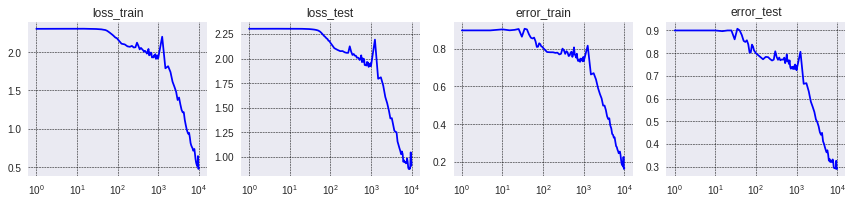

In [38]:
plot_results([obj], nbins=20, figSize=3, obj_labels=None, obj_style=None)



---





---



In [39]:
varying_params = dict(
    width = 200
)


params, filename = main_create_params(varying_params)
obj, elapsed_min = main_run_experiment(params)

Taken 23.4104528705279 minutes. Test error = 0.2668. Test loss = 0.9247726786136627


In [40]:
main_save_results(filename, obj, params, elapsed_min, ROOT_DIR)

/content/nnet_jobtest/lln_nnet_test_w200.pkl is saved and downloaded...


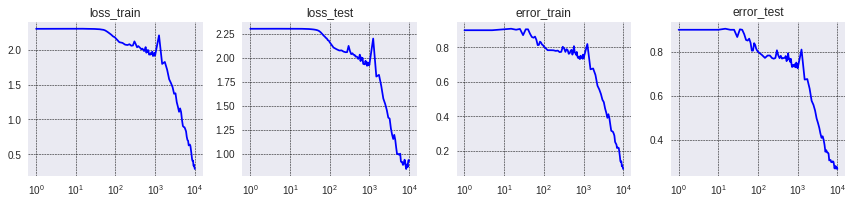

In [42]:
plot_results([obj], nbins=20, figSize=3, obj_labels=None, obj_style=None)



---





---



In [43]:
varying_params = dict(
    width = 400
)


params, filename = main_create_params(varying_params)
obj, elapsed_min = main_run_experiment(params)

Taken 45.90575809876124 minutes. Test error = 0.2675. Test loss = 1.0170731443166732


In [44]:
main_save_results(filename, obj, params, elapsed_min, ROOT_DIR)

/content/nnet_jobtest/lln_nnet_test_w400.pkl is saved and downloaded...


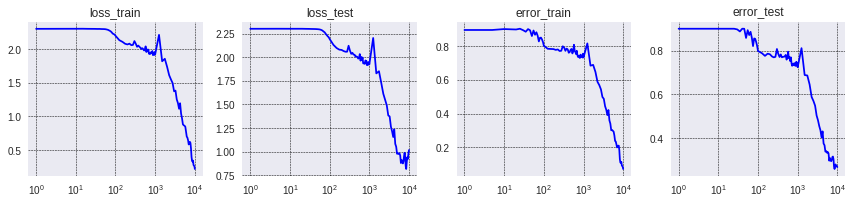

In [45]:
plot_results([obj], nbins=20, figSize=3, obj_labels=None, obj_style=None)



---



---

/content/nnet_jobtest/lln_nnet.eps is saved and downloaded...


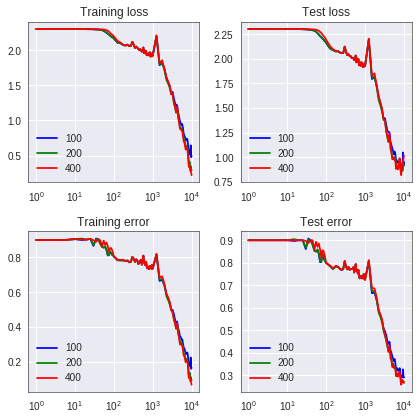

In [8]:
filename_all = ['lln_nnet_test_w100', 'lln_nnet_test_w200', 'lln_nnet_test_w400']
label_all = ['100', '200', '400']
eps_name = 'lln_nnet'

def main_plot_results(filename_all, label_all, eps_name, ROOT_DIR, item_list=None, figSize=3, plt_style=None):
  if item_list==None:
    item_list = ['loss_train', 'loss_test', 'error_train', 'error_test']    
    item_name = ['Training loss', 'Test loss', 'Training error', 'Test error']
 
  if plt_style==None:
    plt_style = ['b-', 'g-', 'r-', 'k-', 'y-', 'm-', 'bx--', 'gx--', 'rx--', 'kx--', 'yx--', 'mx--',\
                 'b.-', 'g.-', 'r.-', 'k.-', 'y.-', 'm.-', 'b*:', 'g*:', 'r*:', 'k*:', 'y*:', 'm*:']
  
  # gather results
  results = dict(    
  )
  for file in filename_all:
    stats, params, elapsed_min = load_pickle(ROOT_DIR + file)
    results[file] = dict(
        output_schedule = params['statsCollect']['output_schedule']
    )    
    for cnt in range(len(item_list)):
        what = item_list[cnt]    
        val = []
        for i in results[file]['output_schedule']:
            val.append(stats[i][what])
        results[file][what] = val
   
  # plot
  nrow = 2
  ncol = np.ceil(len(item_list)/nrow).astype(int)
  fig, ax = plt.subplots(nrow,ncol, figsize=(figSize*ncol,figSize*nrow)) 
  row = 0
  col = -1
  for cnt_item in range(len(item_list)):
    if cnt_item%ncol==0 and cnt_item>0:
      col = -1
      row += 1
    col += 1
    for cnt_file in range(len(filename_all)):    
      what = item_list[cnt_item]
      file = filename_all[cnt_file]
      ax[row][col].semilogx(results[file]['output_schedule'], results[file][what], plt_style[cnt_file%len(plt_style)])
        
    for pos in ['top', 'bottom', 'left', 'right']:
      ax[row][col].spines[pos].set_linewidth(0.5)
      ax[row][col].spines[pos].set_color('black')
    
    #ax[row][col].grid(color='k', linestyle='--', linewidth=0.2)
    ax[row][col].legend(label_all)
    ax[row][col].set_title(item_name[cnt_item])
    
  fig.tight_layout()
  fig.show()  
  
  # download eps  
  fig.savefig(ROOT_DIR + eps_name + '.eps', format='eps', dpi=1000)
  colabFiles.download(ROOT_DIR + eps_name + '.eps')
  
  # print
  print(ROOT_DIR + eps_name + '.eps is saved and downloaded...')
  
main_plot_results(filename_all, label_all, eps_name, ROOT_DIR)